In [1]:
import apogee.tools.read as apread
from apogee.tools import bitmask
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import LogNorm
import window as wn
import os
import access_spectrum as acs
import reduce_dataset as rd
import polyfit as pf
import matplotlib
import apogee.spec.plot as splot
%pylab inline
data = apread.rcsample()
np.random.seed(17)

Populating the interactive namespace from numpy and matplotlib


/Users/Natalie/Code/apogee/apogee/spec/window.py:88: RuntimeWarning: invalid value encountered in greater
  mask= ((win > 0.)*(True-numpy.isnan(win))).astype('int')


In [2]:
font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : 18}

matplotlib.rc('font', **font)

In [28]:
highFe = np.where((data['FE_H']>0.2499) & (data['FE_H']<0.25))[0]

In [29]:
highFe_spec = acs.get_spectra_asp(data[highFe],header = False)

(0, 7214)

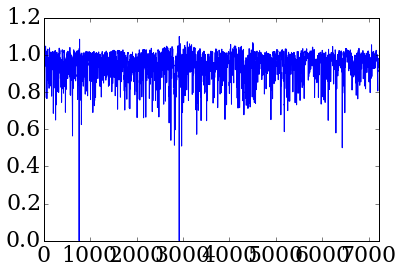

In [34]:
plt.plot(highFe_spec[0])
plt.xlim(0,len(highFe_spec[0]))

In [3]:
# Load in Red Clump sample
ind = np.where(data['FE_H']!=-9999)

In [5]:
pf.hist2d(data['FE_H'][ind],data['ALPHAFE'][ind],labels = ['Abundances in Red Clump Stars','$[Fe/H]$',r'$[\alpha/Fe]$','Number of Stars'],saveloc = '/Users/Natalie/Code/rcapogee-plots/tex/alpha_vs_fe.png')

(array([-0.82736659, -0.80210524, -0.77684389, -0.75158254, -0.72632119,
        -0.70105984, -0.67579849, -0.65053713, -0.62527578, -0.60001443,
        -0.57475308, -0.54949173, -0.52423038, -0.49896903, -0.47370768,
        -0.44844633, -0.42318498, -0.39792363, -0.37266227, -0.34740092,
        -0.32213957, -0.29687822, -0.27161687, -0.24635552, -0.22109417,
        -0.19583282, -0.17057147, -0.14531012, -0.12004877, -0.09478742,
        -0.06952606, -0.04426471, -0.01900336,  0.00625799,  0.03151934,
         0.05678069,  0.08204204,  0.10730339,  0.13256474,  0.15782609,
         0.18308744,  0.2083488 ,  0.23361015,  0.2588715 ,  0.28413285,
         0.3093942 ,  0.33465555,  0.3599169 ,  0.38517825,  0.4104396 ,
         0.43570095]),
 array([-0.16740933, -0.15690844, -0.14640755, -0.13590666, -0.12540578,
        -0.11490489, -0.104404  , -0.09390311, -0.08340222, -0.07290133,
        -0.06240044, -0.05189955, -0.04139866, -0.03089778, -0.02039689,
        -0.009896  ,  0.0006

In [4]:
# Load in spectra
label = 'FE_H'
low = -0.5
up = -0.4
sliceinfo = [label,low,up]
sindx = rd.slice_data(data, sliceinfo)
sdata = data[sindx]
maskdata = acs.get_spectra_ap(sdata,ext = 3, header = False,indx = 1)
ints = [i for i in range(len(maskdata)) if not isinstance(maskdata[i],np.int16)]
maskdata = maskdata[ints]
maskdata = np.array(list(maskdata),dtype = np.int64)
specs = acs.get_spectra_asp(sdata,header = False)
specs = specs[ints]
errs = acs.get_spectra_asp(sdata,ext = 2, header = False)
errs = errs[ints]

In [5]:
# Find fit residuals
O = 2
badcombpixmask= bitmask.badpixmask()+2**bitmask.apogee_pixmask_int("SIG_SKYLINE")
direc = './red_clump/pickles/'
pdirec = './red_clump/fitplots/'
ressname = 'rcresiduals_order{0}_{1}_u{2}_d{3}.pkl'.format(O,label,low,up)
gname = 'rcgerr_order{0}_{1}_u{2}_d{3}.pkl'.format(O,label,low,up)
ngen = True
if os.path.isfile(direc+ressname) and ngen:
    ress = acs.pklread(direc+ressname)
    gerr = acs.pklread(direc+gname)
elif not os.path.isfile(direc+ressname) or not ngen:
    ps = []
    ress = []
    gerr = []
    discard = []
    for pix in range(len(specs[0])):
        mask,badspec = rd.pixmask_find(maskdata,pix,bitval = badcombpixmask)
        mdata = sdata[mask]
        mspecs = specs[mask]
        merrs = errs[mask]
        Teff = np.arange(min(mdata['TEFF']),max(mdata['TEFF']))
        logg = np.arange(min(mdata['LOGG']),max(mdata['LOGG']),((max(mdata['LOGG']-min(mdata['LOGG'])))/len(Teff)))
        metals = np.arange(min(mdata['METALS']),max(mdata['METALS']),((max(mdata['METALS']-min(mdata['METALS'])))/len(Teff)))
        discard.append('{0} of {1}'.format(len(sdata)-len(mask[0]),len(sdata)))
        res = np.zeros(len(specs))
        erarr = np.zeros(len(specs))
        try:
            nonzero = np.where(mspecs[:,pix] != 0)
            p = pf.regfit((mdata['TEFF'],mdata['LOGG'],mdata['FE_H']),mspecs[:,pix],err = merrs[:,pix],order = O)
            ps.append(p)
            res[mask] = mspecs[:,pix] - pf.poly(p,(mdata['TEFF'],mdata['LOGG'],mdata['METALS']),order = O)
            if totalw[pix] != 0:
                pl = np.where((merrs[:,pix] < 0.1) & (mspecs[:,pix] != 0))
                rpl = np.where((merrs[:,pix] > 0.1) & (mspecs[:,pix] != 0))
                plt.figure(figsize = (12,10))
                plt.subplot2grid((3,3),(0,0))
                plt.errorbar(mdata['TEFF'][pl],mspecs[:,pix][pl],yerr = merrs[:,pix][pl],fmt='.')
                plt.plot(Teff,pf.poly(p,(Teff,logg,metals),order = O),linewidth = 3)
                plt.plot(mdata['TEFF'][rpl],mspecs[:,pix][rpl],'.')
                plt.xlabel('T_EFF')
                plt.ylabel('Pixel {0}'.format(pix))
                plt.subplot2grid((3,3),(1,0))
                plt.plot(mdata['TEFF'][pl],res[pl],'.')
                plt.xlabel('T_EFF')
                plt.ylabel('Fit residuals')
                plt.subplot2grid((3,3),(2,0))
                plt.semilogx(errs[:,pix][pl],res[pl],'.')
                plt.xlabel('Uncertainty in Pixel {0}'.format(pix))
                plt.ylabel('Fit residuals')
                plt.subplot2grid((3,3),(0,1))
                plt.errorbar(mdata['LOGG'][pl],mspecs[:,pix][pl],yerr = merrs[:,pix][pl],fmt='.')
                plt.plot(logg,pf.poly(p,(Teff,logg,metals),order = O),linewidth = 3)
                plt.plot(mdata['LOGG'][rpl],mspecs[:,pix][rpl],'.')
                plt.xlabel('LOG(G)')
                plt.ylabel('Pixel {0}'.format(pix))
                plt.subplot2grid((3,3),(1,1))
                plt.plot(mdata['LOGG'][pl],res[pl],'.')
                plt.xlabel('LOG(G)')
                plt.ylabel('Fit residuals')
                plt.tight_layout()
                plt.subplot2grid((3,3),(0,2))
                plt.errorbar(mdata['METALS'][pl],mspecs[:,pix][pl],yerr = merrs[:,pix][pl],fmt='.')
                plt.plot(metals,pf.poly(p,(Teff,logg,metals),order = O),linewidth = 3)
                plt.plot(mdata['METALS'][rpl],mspecs[:,pix][rpl],'.')
                plt.xlabel('Metallicity')
                plt.ylabel('Pixel {0}'.format(pix))
                plt.subplot2grid((3,3),(1,2))
                plt.plot(mdata['METALS'][pl],res[pl],'.')
                plt.xlabel('Metallicity')
                plt.ylabel('Fit residuals')
                plt.tight_layout()
                print pdirec+'pix{0}fit_order{1}_{2}_u{3}_d{4}.png'.format(pix,O,label,low,up)
                plt.savefig(pdirec+'pix{0}fit_order{1}_{2}_u{3}_d{4}.png'.format(pix,O,label,low,up))
                plt.close()
            ress.append(res)
            for mval in mask[0]:
                if specs[mval][pix] != 0:
                    erarr[mask[0][mval]] = np.random.normal(0,errs[mval][pix])/specs[mval][pix]
                if specs[mval][pix] == 0:
                    erarr[mask[0][mval]] = np.random.normal(0,errs[mval][pix])
            gerr.append(erarr)
        except LinAlgError:
            continue
    ress = np.array(ress)
    gerr = np.array(gerr)
    dfile = open(direc+'dis_'+ressname.split('.pkl')[0]+'.txt','wb')
    dfile.write("\n".join(discard))
    acs.pklwrite(direc+'fitparam_order{0}_{1}_u{2}_d{3}.png'.format(O,label,low,up),ps)
    acs.pklwrite(direc+ressname,ress)
    acs.pklwrite(direc+gname,gerr)

Al [6273 6274 6275 6276 6277 6278 6279 6280 6281 6282 6283 6284 6285 6286 6287
 6288 6289 6290 6291 6292 6293 6294 6295 6296 6297 6298 6299 6300 6301 6302
 6303 6304 6305 6306 6307 6308 6309 6310 6311 6312 6313 6314 6315 6316 6317
 6318 6319 6320 6477 6478 6479 6480 6481 6482 6483 6484 6485 6486 6487 6488
 6489 6490 6491 6492 6493 6494 6495 6496 6497]
Ca [4180 4181 4182 4183 4184 4185 4186 4187 4188 4189 4190 4191 4192 4193]
C [ 604  605  606  607  608  609  610  611  612  613  614  615  616  617  618
  619  620  621  622  623  624  625  626  627  628  629  630  631  632  633
  634  635  636  637  638  639  640  641  642  720  721  722  723  724  725
  726  727  728  729  730  731  732  733  734  735  736  737  738  739  740
  741  742  743  744  745  746  747  748  749  750  751  752  753  754  755
  756  757  758  759  760  761  762  763  764  765  766  767  768  769  770
  771  772  773  774  775  776  777  778  779  780  781  782  783  784  785
  786  787  788  789  790  791  792  

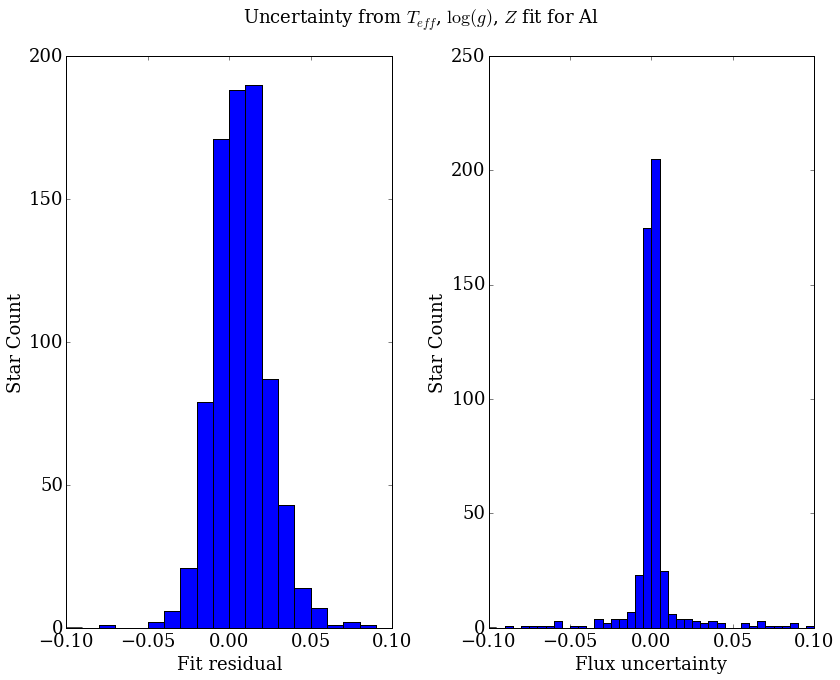

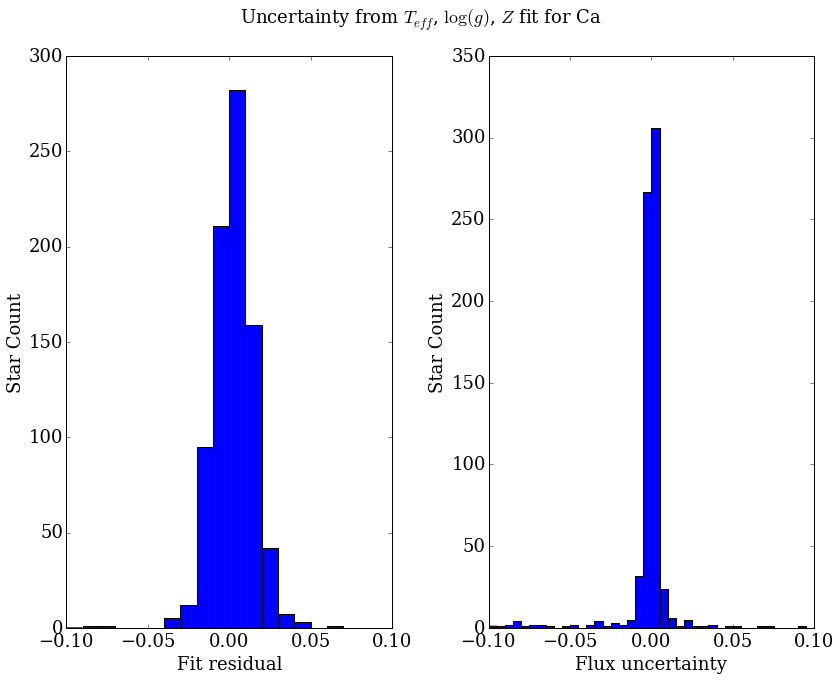

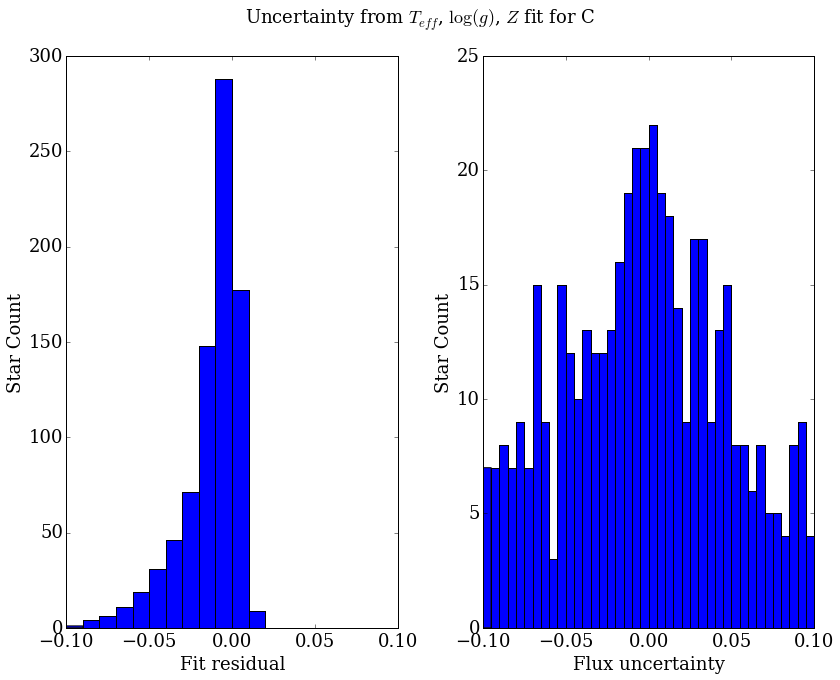

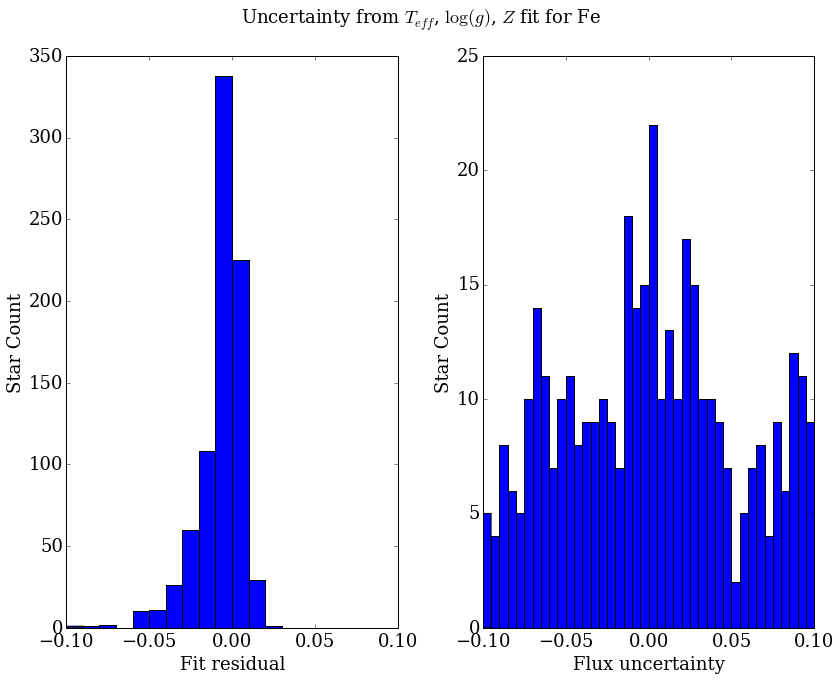

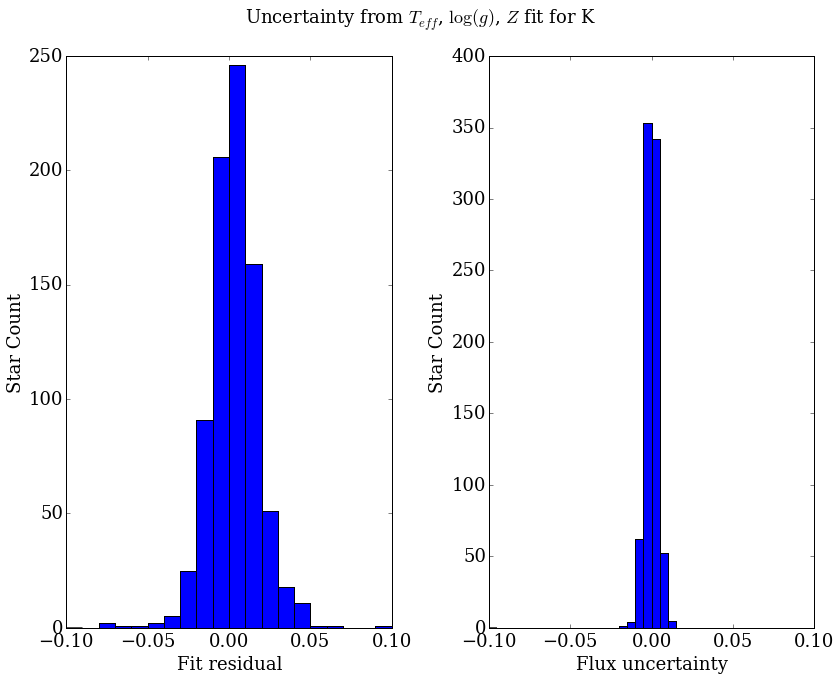

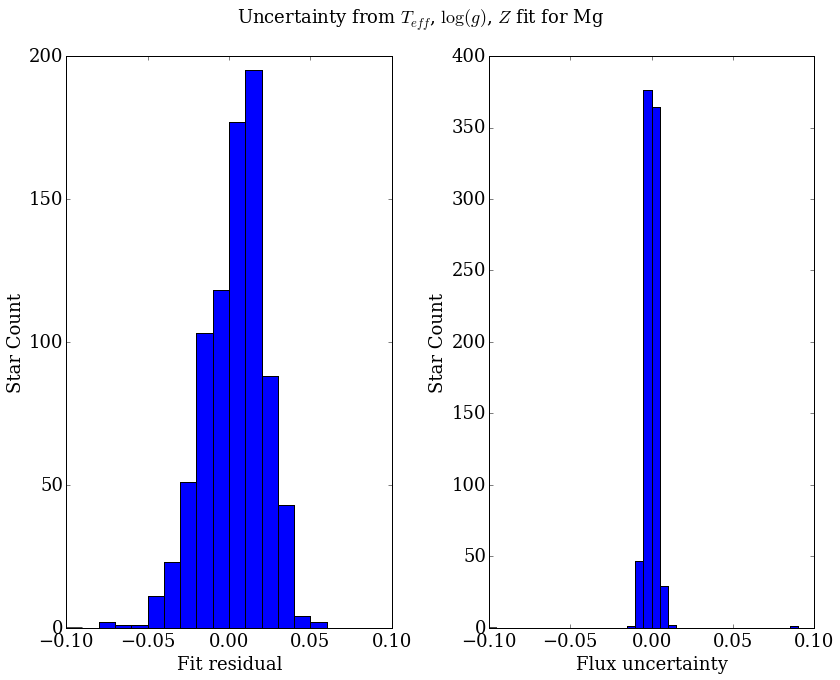

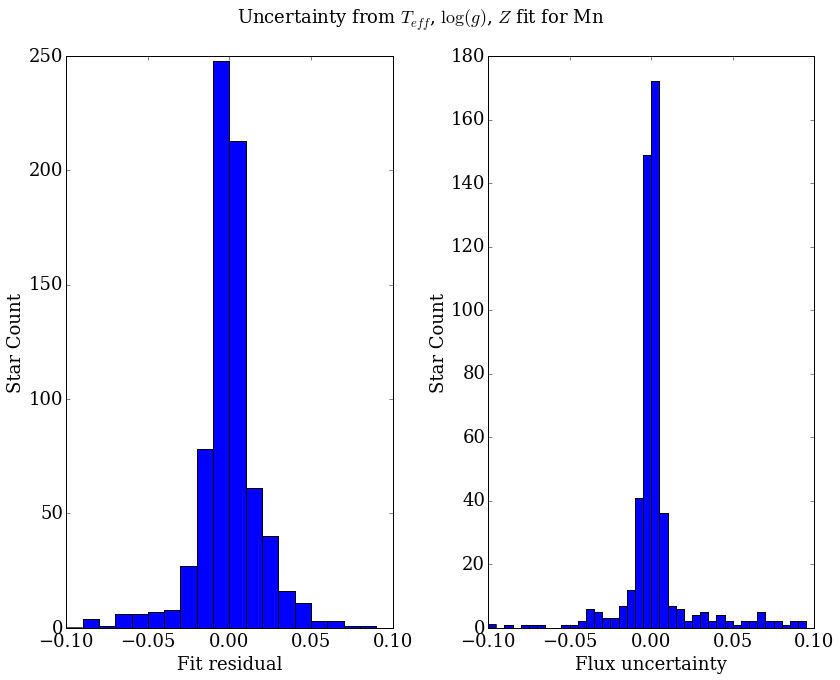

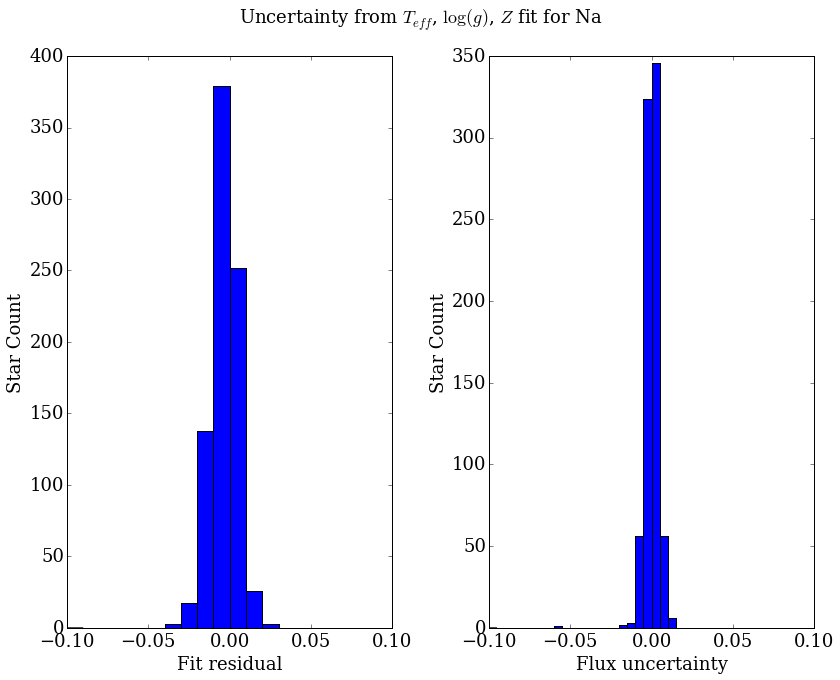

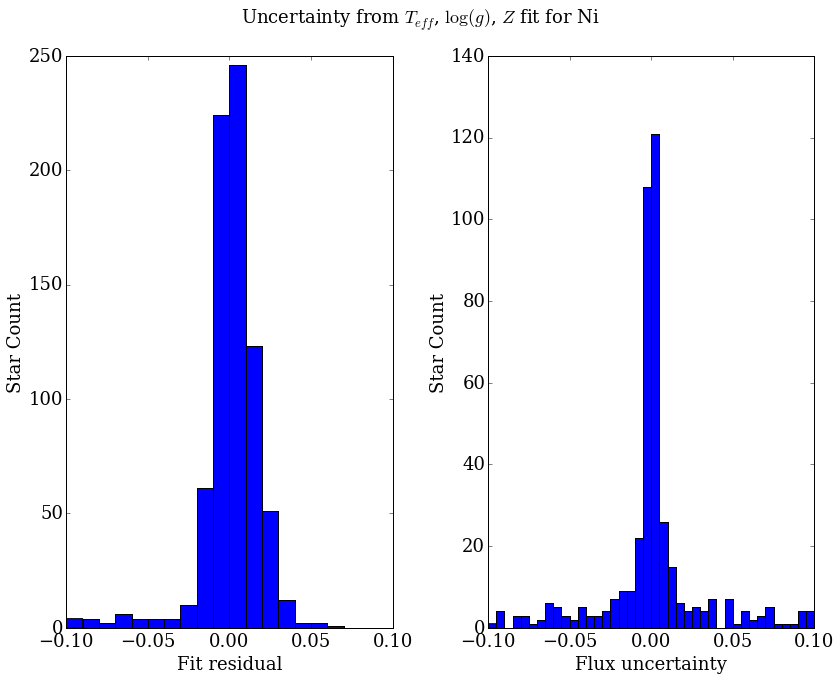

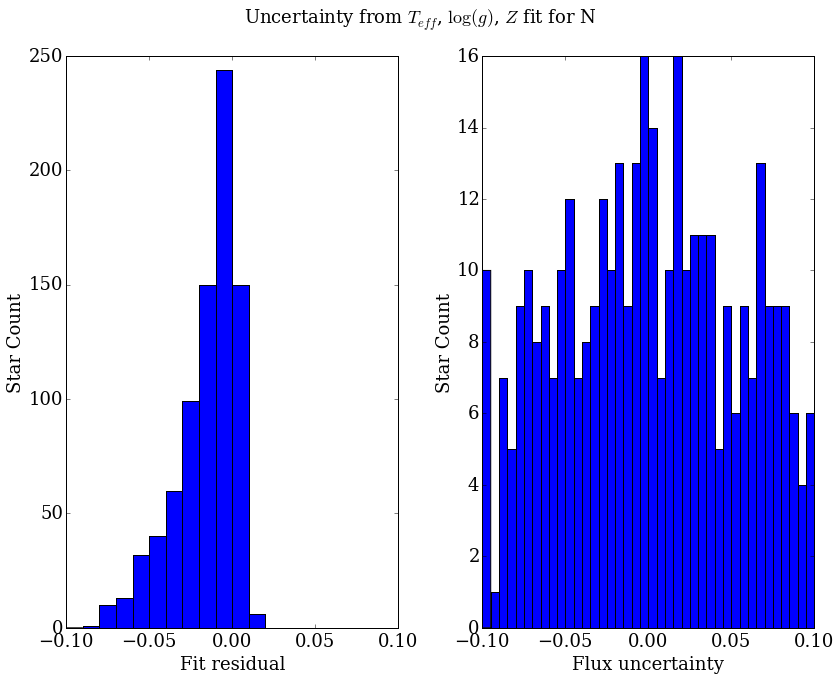

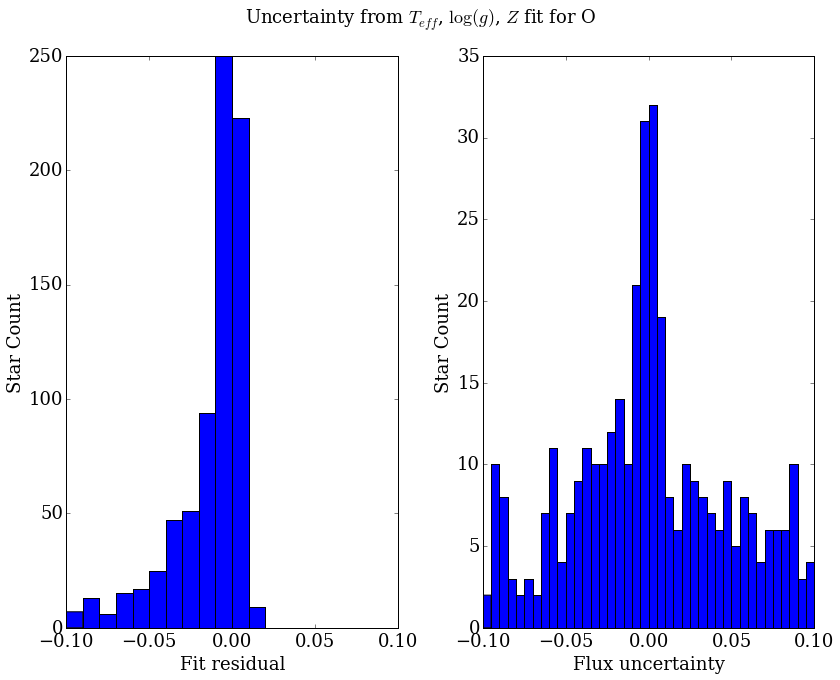

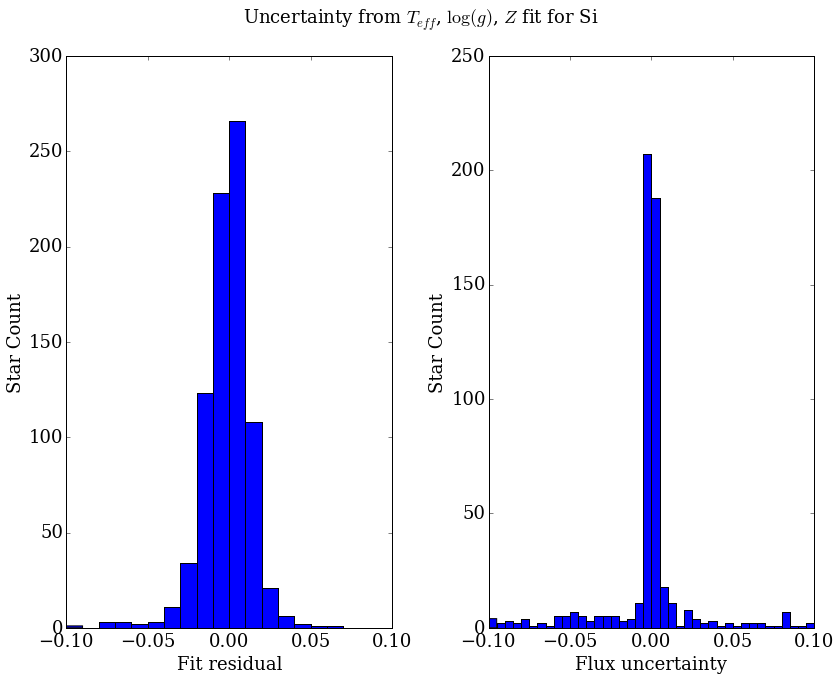

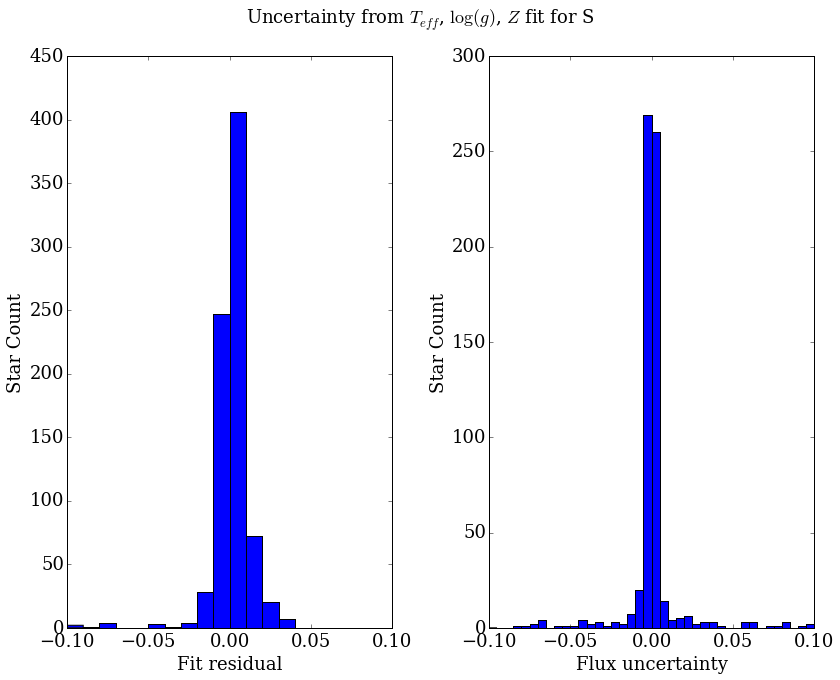

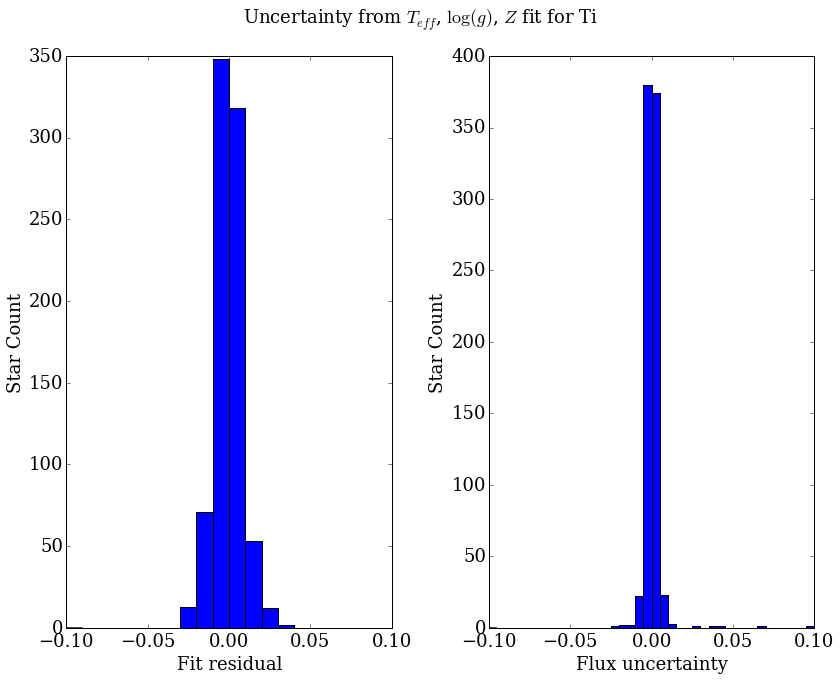

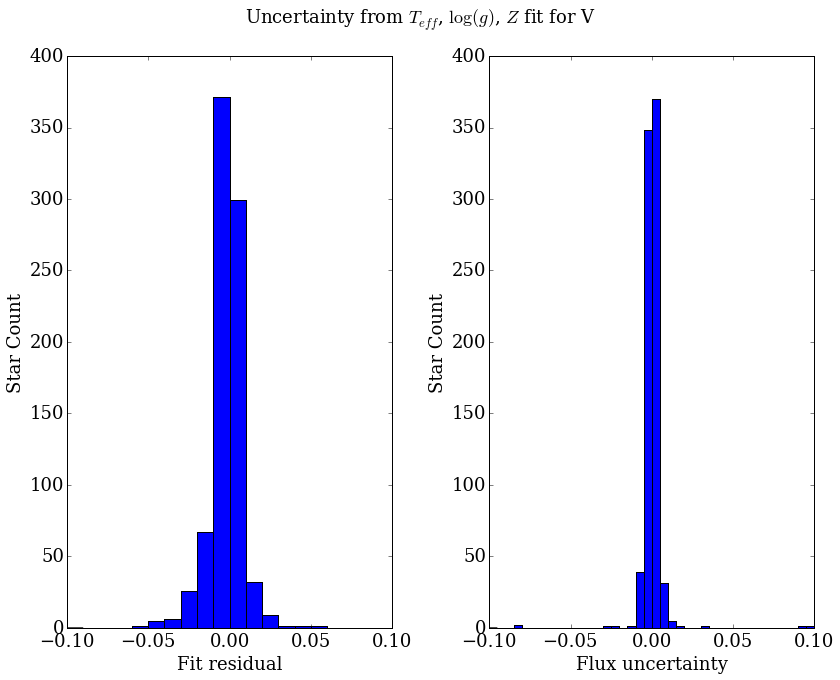

In [7]:
doplot = True
# Plot residuals for each element
elems = ['Al','Ca','C','Fe','K','Mg','Mn','Na','Ni','N','O','Si','S','Ti','V']
rdirec = './red_clump/residual_plots'
totalw = np.zeros(len(specs[0]))
for elem in elems:
    w = wn.read(elem,dr = 12,apStarWavegrid=False)
    totalw += w
    th = wn.tophat(elem,dr=12,apStarWavegrid=False)
    print elem,np.where(th==True)[0]
    nw = pf.normweights(w)[th]
    #print np.where(np.isnan(nw)==True)
    resids = []
    gresid = []
    for star in range(len(ress[0])):
        resids.append(pf.genresidual(nw,ress[:,star][th]))
        #print pf.genresidual(nw,gerr[:,star][th])
        gresid.append(pf.genresidual(nw,gerr[:,star][th]))
    resids = np.array(resids)
    gresid = np.array(gresid)
    acs.pklwrite(direc+'{0}_residuals_order{1}_{2}_u{3}_d{4}.pkl'.format(elem,O,label,low,up),resids)
    if doplot:
        plt.figure(figsize = (12,10))
        allow = np.where(np.isnan(gresid) == False)
        #print len(allow[0])
        Rhist = np.histogram(resids[allow],bins = 50,density=True,range=(-0.1,0.1))
        Ghist = np.histogram(gresid[allow],bins = 50,density=True,range=(-0.1,0.1))
        plt.subplot(121)
        #plt.hist(Rhist[0]/max(Rhist[0]),bins = Rhist[1])
        plt.hist(resids[allow],bins = 20,range = (-0.1,0.1),stacked=True)
        plt.xlim(-0.1,0.1)
        plt.xlabel('Fit residual')
        plt.ylabel('Star Count')
        plt.suptitle('Uncertainty from $T_{eff}$, $\log(g)$, $Z$ fit for '+elem)
        plt.subplot(122)
        plt.hist(gresid[allow],bins = 40,range = (-0.1,0.1),stacked=True)
        plt.xlabel('Flux uncertainty'.format(elem))
        plt.ylabel('Star Count')
        plt.xlim(-0.1,0.1)
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.savefig(direc+'{0}_residuals_order{1}_{2}_u{3}_d{4}.png'.format(elem,O,label,low,up))

In [28]:
totalw

array([  1.43293900e-02,   8.33550000e-04,   6.19000000e-06, ...,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00])

In [6]:
# Plot results for Aluminum line
doplot = True
if doplot:
    pix = 3273
    p = ps[0]
    res = ress[0]
    mask,badspec = rd.pixmask_find(maskdata,pix,bitval = badcombpixmask)
    mdata = sdata[mask]
    mspecs = specs[mask]
    merrs = errs[mask]
    Teff = np.arange(min(mdata['TEFF']),max(mdata['TEFF']))
    logg = np.arange(min(mdata['LOGG']),max(mdata['LOGG']),((max(mdata['LOGG']-min(mdata['LOGG'])))/len(Teff)))
    metals = np.arange(min(mdata['METALS']),max(mdata['METALS']),((max(mdata['METALS']-min(mdata['METALS'])))/len(Teff)))
    pl = np.where(merrs[:,pix] < 0.1)
    rpl = np.where(merrs[:,pix] > 0.1)
    plt.figure(figsize = (10,8))
    plt.subplot2grid((3,3),(0,0))
    plt.errorbar(mdata['TEFF'][pl],mspecs[:,pix][pl],yerr = merrs[:,pix][pl],fmt='.')
    plt.plot(Teff,pf.poly(p,(Teff,logg,metals),order = O),linewidth = 3)
    plt.plot(mdata['TEFF'][rpl],mspecs[:,pix][rpl],'.')
    plt.xlabel('T_EFF')
    plt.ylabel('Pixel {0}'.format(pix))
    plt.ylim(0.7,1)
    plt.subplot2grid((3,3),(1,0))
    plt.plot(mdata['TEFF'][pl],res[pl],'.')
    plt.xlabel('T_EFF')
    plt.ylabel('Fit residuals')
    plt.subplot2grid((3,3),(2,0))
    plt.semilogx(errs[:,pix][pl],res[pl],'.')
    plt.xlabel('Uncertainty in Pixel {0}'.format(pix))
    plt.ylabel('Fit residuals')
    plt.subplot2grid((3,3),(0,1))
    plt.errorbar(mdata['LOGG'][pl],mspecs[:,pix][pl],yerr = merrs[:,pix][pl],fmt='.')
    plt.plot(logg,pf.poly(p,(Teff,logg,metals),order = O),linewidth = 3)
    plt.plot(mdata['LOGG'][rpl],mspecs[:,pix][rpl],'.')
    plt.xlabel('LOG(G)')
    plt.ylabel('Pixel {0}'.format(pix))
    plt.subplot2grid((3,3),(1,1))
    plt.plot(mdata['LOGG'][pl],res[pl],'.')
    plt.xlabel('LOG(G)')
    plt.ylabel('Fit residuals')
    plt.tight_layout()
    plt.subplot2grid((3,3),(0,2))
    plt.errorbar(mdata['METALS'][pl],mspecs[:,pix][pl],yerr = merrs[:,pix][pl],fmt='.')
    plt.plot(metals,pf.poly(p,(Teff,logg,metals),order = O),linewidth = 3)
    plt.plot(mdata['METALS'][rpl],mspecs[:,pix][rpl],'.')
    plt.xlabel('Metallicity')
    plt.ylabel('Pixel {0}'.format(pix))
    plt.subplot2grid((3,3),(1,2))
    plt.plot(mdata['METALS'][pl],res[pl],'.')
    plt.xlabel('Metallicity')
    plt.ylabel('Fit residuals')

NameError: name 'ps' is not defined

(array([   0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    1.,    0.,    0.,    0.,    2.,    1.,    1.,    4.,
          13.,   15.,   27.,   42.,   69.,   69.,   95.,  124.,  135.,
         111.,   61.,   35.,   11.,    4.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.]),
 array([-0.2  , -0.192, -0.184, -0.176, -0.168, -0.16 , -0.152, -0.144,
        -0.136, -0.128, -0.12 , -0.112, -0.104, -0.096, -0.088, -0.08 ,
        -0.072, -0.064, -0.056, -0.048, -0.04 , -0.032, -0.024, -0.016,
        -0.008,  0.   ,  0.008,  0.016,  0.024,  0.032,  0.04 ,  0.048,
         0.056,  0.064,  0.072,  0.08 ,  0.088,  0.096,  0.104,  0.112,
         0.12 ,  0.128,  0.136,  0.144,  0.152,  0.16 ,  0.168,  0.176,
         0.184,  0.192,  0.2  ]),
 <a list of 50 Patch objects>)

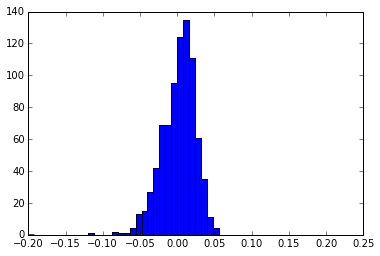

In [48]:
plt.hist(res,bins = 50,range=(-0.2,0.2))

In [ ]:
if doplot:
    fig = plt.figure(figsize = (10,8))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot(mdata['TEFF'],mdata['LOGG'],specs[:,6296],'.')
    ax.plot(Teff,logg,poly_indep(p,(Teff,logg,metals)))

In [46]:
from read_clusterdata import read_caldata
dat = read_caldata()

In [47]:
dat['APOGEE_ID'] = dat['ID']

In [48]:
specsfile = 'specs_cdata.pkl'
errsfile = 'errs_cdata.pkl'
if os.path.isfile(specsfile):
    specs,ind = acs.pklread(specsfile)
    errs,ind = acs.pklread(errsfile)
else:
    specdata = acs.get_spectra_asp(dat,header = False)
    errdata= acs.get_spectra_asp(dat,ext = 2, header = False)
    acs.pklwrite(specsfile,specdata)
    acs.pklwrite(errsfile,errdata)
    specs,ind = specdata
    errs,ind = errdata  

File aspcapStar-r5-v603-2M03403073+2429143.fits does not appear to exist on the server ...
File aspcapStar-r5-v603-2M03405126+2335544.fits does not appear to exist on the server ...
File aspcapStar-r5-v603-2M03413958+2345471.fits does not appear to exist on the server ...
File aspcapStar-r5-v603-2M03415366+2327287.fits does not appear to exist on the server ...
File aspcapStar-r5-v603-2M03415868+2342263.fits does not appear to exist on the server ...
File aspcapStar-r5-v603-2M03420383+2442454.fits does not appear to exist on the server ...
File aspcapStar-r5-v603-2M03422154+2439527.fits does not appear to exist on the server ...
File aspcapStar-r5-v603-2M03422760+2502492.fits does not appear to exist on the server ...
File aspcapStar-r5-v603-2M03424189+2411583.fits does not appear to exist on the server ...
File aspcapStar-r5-v603-2M03432662+2459395.fits does not appear to exist on the server ...
File aspcapStar-r5-v603-2M03433660+2327141.fits does not appear to exist on the server ...

In [49]:
O = 2
dat = dat[ind]
Tkeep = np.where(dat['TEFF']!=0)
dat = dat[Tkeep]
specs = specs[Tkeep]
errs = errs[Tkeep]
np.unique(dat['CLUSTER'])

M107
M13
M15
M2
M3
M5
M53
M67
M71
M92
N188


In [50]:
# Pick cluster
cluster = 'M13'
Ckeep = np.where(dat['CLUSTER']==cluster)
dat = dat[Ckeep]
specs = specs[Ckeep]
errs = errs[Ckeep]

In [51]:
# Find fit residuals
direc = './open_clusters/pickles'
ressname = 'cresiduals_order{0}.pkl'.format(O)
ngen = False
if os.path.isfile(direc+ressname) and ngen:
    ress = acs.pklread(direc+ressname)
elif not os.path.isfile(direc+ressname) or not ngen:
    ps = []
    ress = []
    discard = []
    for pix in range(len(specs[0])):
        #mask,badspec = rd.pixmask_find(maskdata,pix,bitval = badcombpixmask)
        #mdata = sdata[mask]
        #mspecs = specs[mask]
        #merrs = errs[mask]
        #discard.append('{0} of {1}'.format(len(sdata)-len(mask[0]),len(sdata)))
        res = np.zeros(len(specs))
        try:
            p = pf.regfit(dat['TEFF'],specs[:,pix],err = errs[:,pix],order = O)
            ps.append(p)
            res = specs[:,pix] - pf.poly(p,dat['TEFF'],order = O)
            ress.append(res)
            #plt.figure()
            #plt.plot(dat['TEFF'],specs[:,pix],'.')
            #plt.plot(dat['TEFF'],pf.poly(p,dat['TEFF'],order = O))
        except LinAlgError:
            continue
    ress = np.array(ress)
    #dfile = open('dis_'+ressname.split('.pkl')[0]+'.txt','wb')
    #dfile.write("\n".join(discard))
    acs.pklwrite(direc+ressname,ress) 

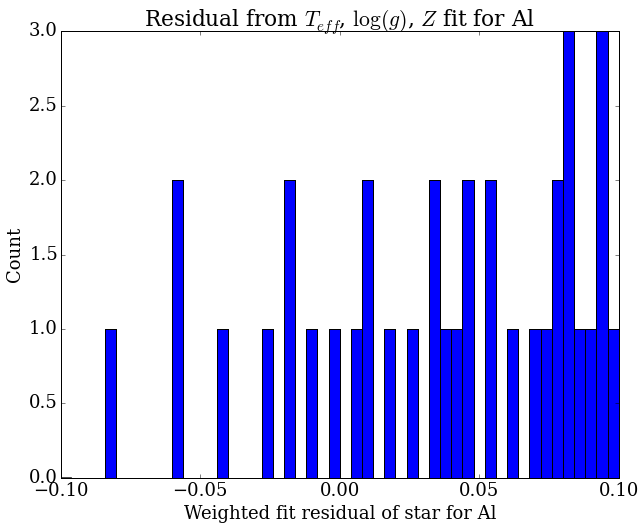

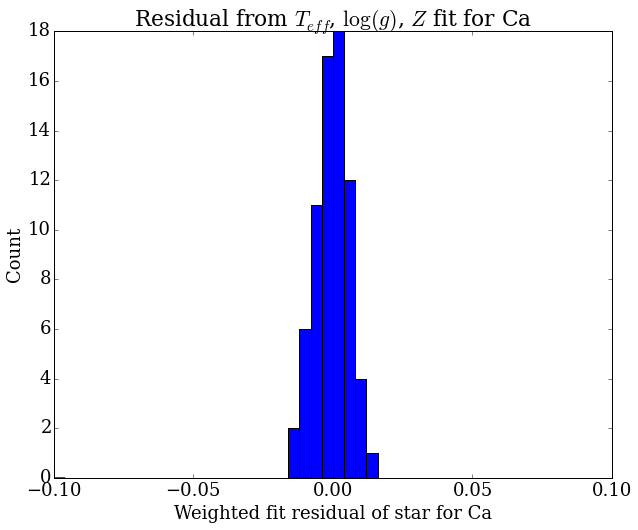

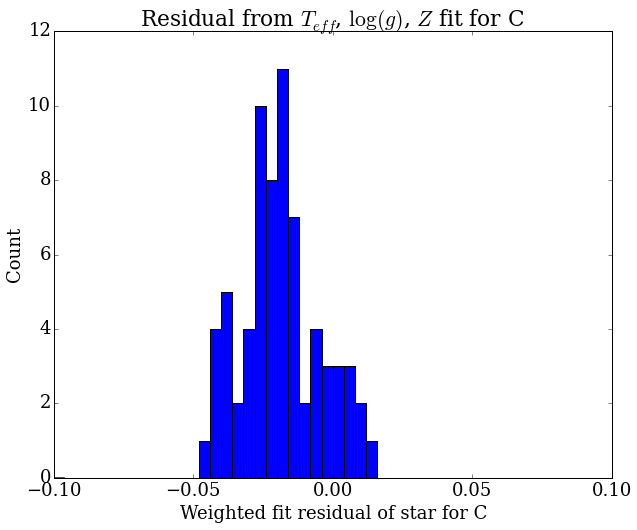

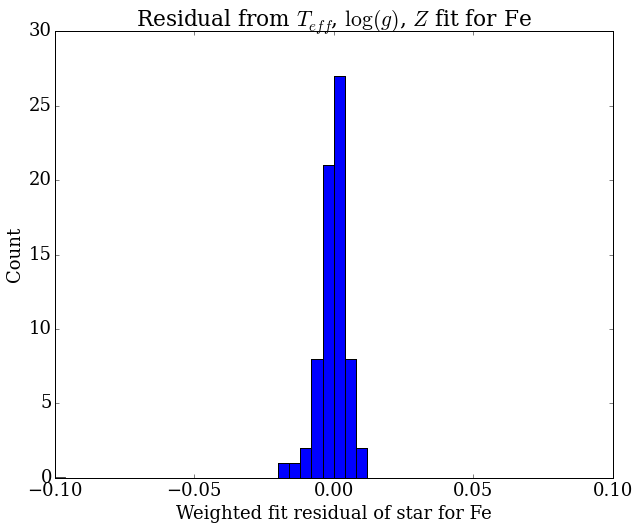

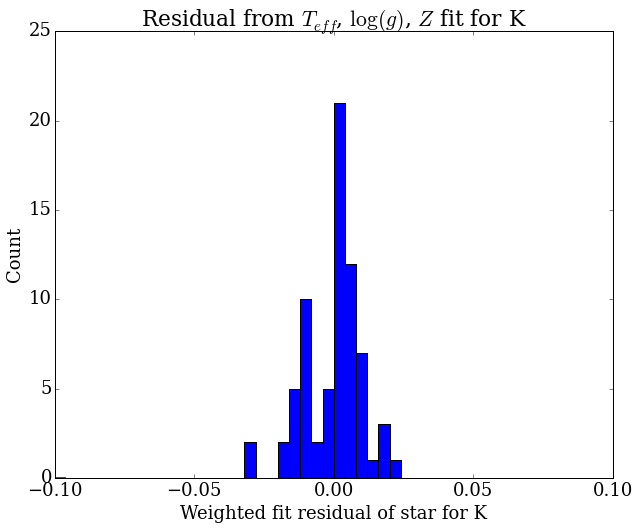

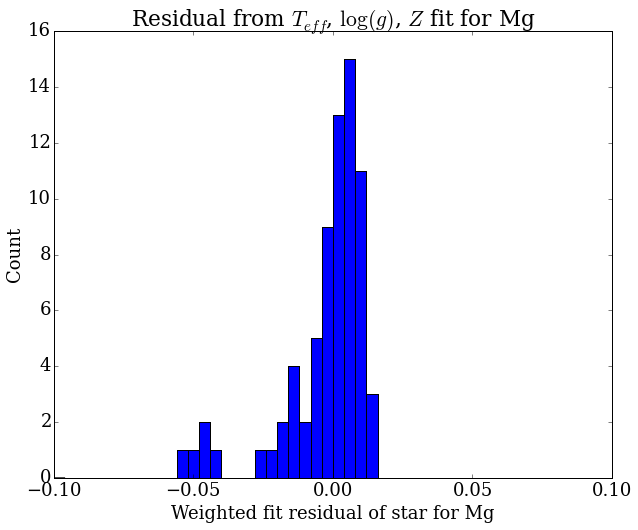

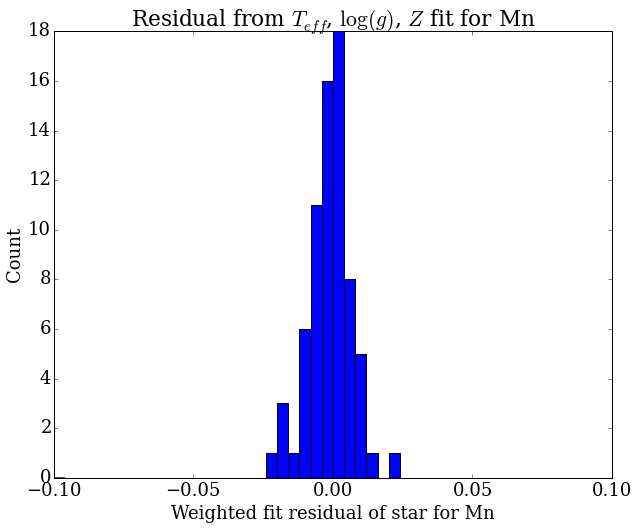

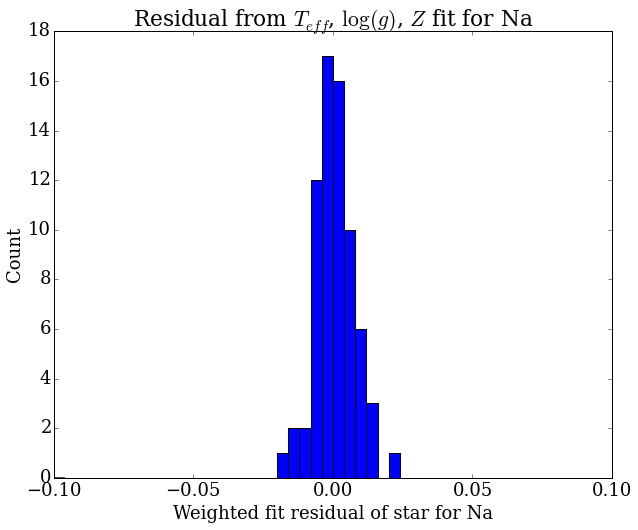

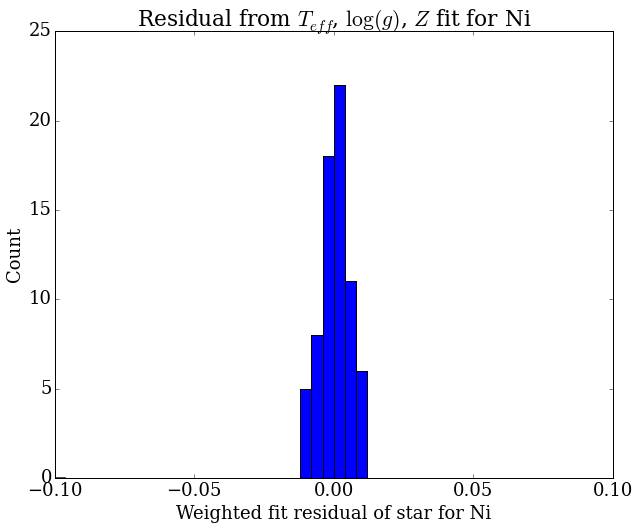

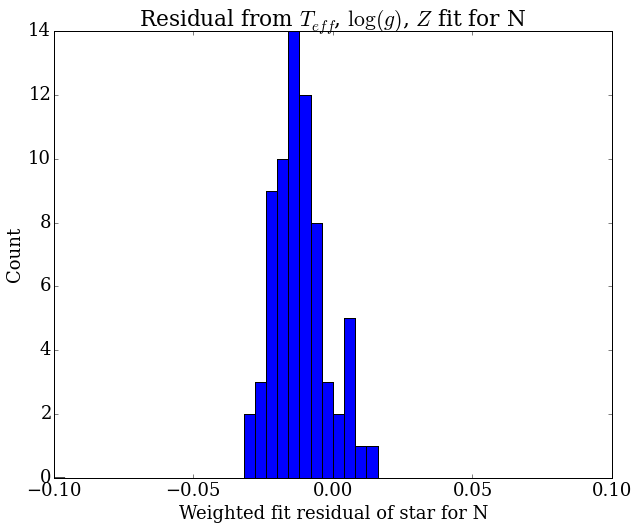

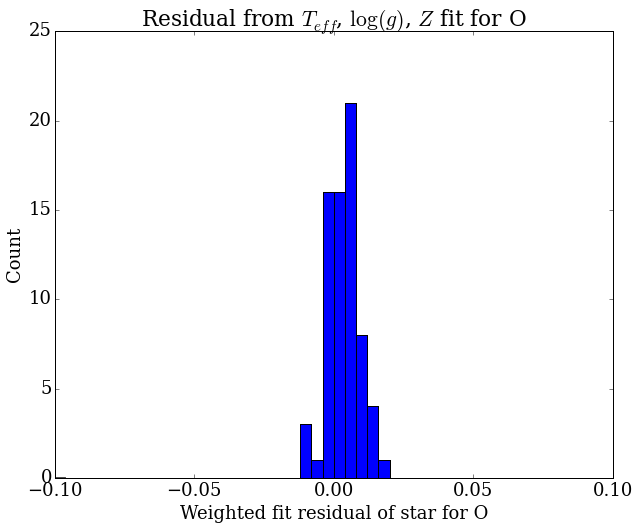

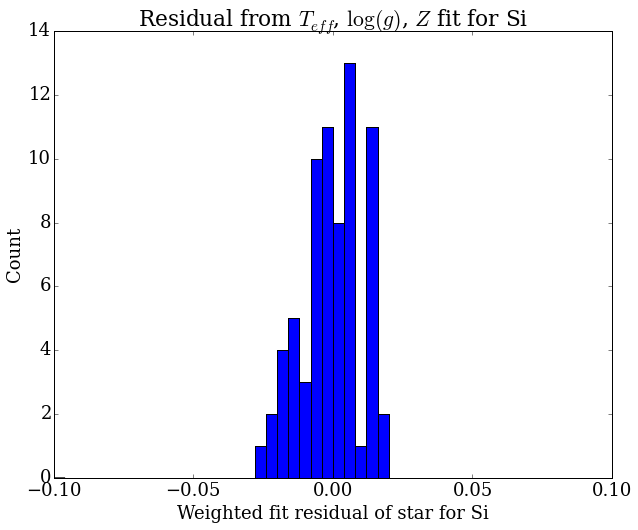

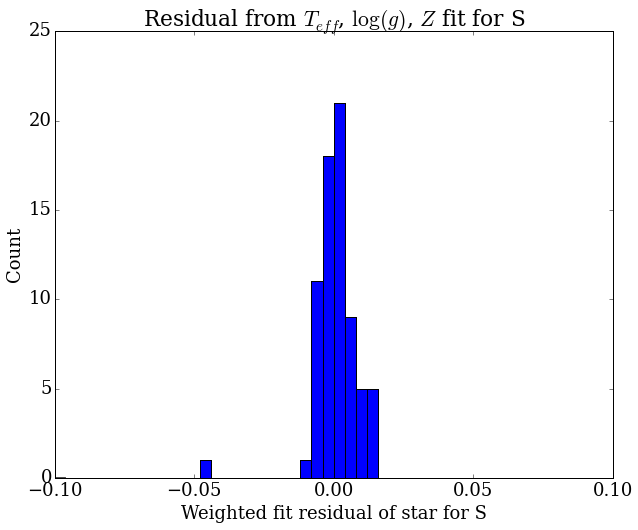

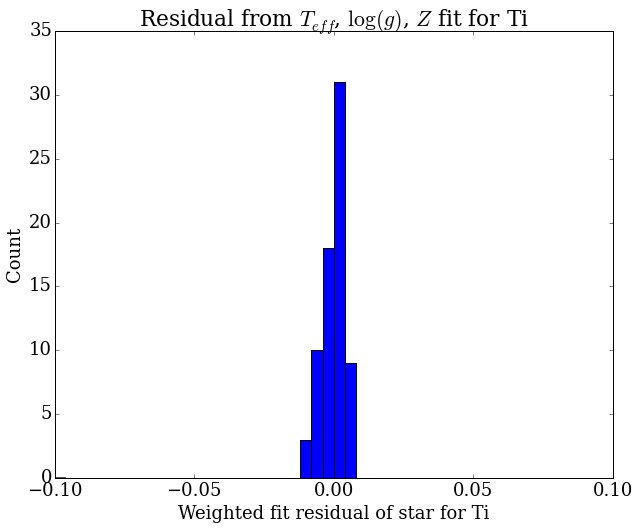

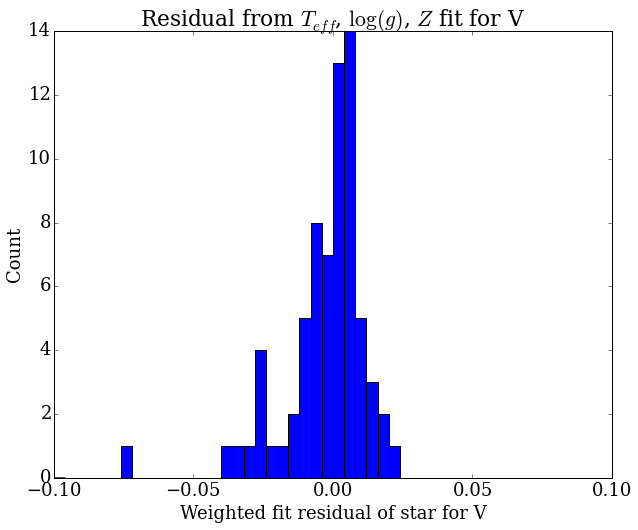

In [53]:
elems = ['Al','Ca','C','Fe','K','Mg','Mn','Na','Ni','N','O','Si','S','Ti','V']
pdirec = './open_clusters/residual_plots'
for elem in elems:
    w = wn.read(elem,dr = 12,apStarWavegrid=False)
    th = wn.tophat(elem,dr=12,apStarWavegrid=False)
    th = np.where(th == True)
    nw = pf.normweights(w)[th]
    resids = []
    for star in range(len(ress[0])):
        resids.append(pf.genresidual(nw,ress[:,star][th]))
    acs.pklwrite(direc+'{0}_cresiduals{1}_order{2}.pkl'.format(elem,cluster,O),resids)
    plt.figure(figsize = (10,8))
    plt.hist(resids,bins = 50,range=(-0.1,0.1))
    plt.xlim(-0.1,0.1)
    plt.xlabel('Weighted fit residual of star for {0}'.format(elem))
    plt.ylabel('Count')
    plt.title('Residual from $T_{eff}$, $\log(g)$, $Z$ fit for '+elem)
    plt.savefig(pdirec+'{0}_cresiduals{1}_order{2}.png'.format(elem,cluster,O))